In [1]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

# util
import numpy as np

# date & time
from datetime import timezone, date, datetime
from dateutil.relativedelta import relativedelta as rdelta
from dateutil.rrule import rrule, MONTHLY

# output processing and plotting
import io
import tarfile
import rasterio
from rasterio.plot import show
from matplotlib import pyplot

# Oauth
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

## Get authorization token

In [2]:
# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

## Configure request (evalscript)

Enter start and end date, input bands, indices. The resulting files will have two time intervals per month, being split at `day_of_new_interval`.

In [3]:
startdate = date(2018,9,1) # Y,M,D
enddate = date(2018,9,15)  # Y,M,D

input_bands = ["B02",
               "B03",
               "B04",
               "B05",
               "B06",
               "B07",
               "B08",
               "B8A",
               "B11",
               "B12"]
indices = ['NDVI',
           "GNDVI",
           "BNDVI",
           "NDWI",
           "CVI",
           "NDSI"]

bucket_name = "eox-masterdatacube"

day_of_new_interval = 16 # leave this unchanged in most of the cases

### Calculate parameters

In [4]:
starttime = datetime(*startdate.timetuple()[:6])
endtime = datetime(*enddate.timetuple()[:6])

d=day_of_new_interval
full_month_dates = list(rrule(MONTHLY, dtstart=startdate, until=enddate, bymonthday=[1,d-1,d,31]))
all_dates = [starttime] + full_month_dates + [endtime] # bounds of all intervals

starts = all_dates[0::2]
starts = [int(d.timestamp()) for d in starts] # timestamps for arithmetic
ends   = [d+rdelta(hour=23, minute=59, second=59) for d in all_dates[1::2]]
ends   = [int(d.timestamp()) for d in ends]   # timestamps for arithmetic
avg_times = list(np.mean(list(zip(starts,ends)), axis=1))
avg_times = [datetime.utcfromtimestamp(a) for a in avg_times]
avg_times = [dt.isoformat() for dt in avg_times]

In [5]:
masks = ["SCL", "dataMask"] # SCL ... Scene Classification Layer

output_bands = input_bands + indices
output_array =  ','.join([f"{{id: '{ob}', bands: {len(avg_times)}, "+
                          f"sampleType: SampleType.UINT16}}" for ob in output_bands])
int_bands = '{' + ','.join([f'{ib}: []' for ib in input_bands]) + '}'
results_object = '{' + ','.join([f'{ob}: []' for ob in output_bands]) + '}'
debug_results = '{' + ','.join([f"{output_bands[i]}: [{i+1}]" for i in range(len(output_bands))]) + '}'
responses = [{"identifier": ob,"format": {"type": "image/tiff"}} for ob in output_bands]

### Evalscript & Payload

In [6]:
#double curly brackets render as single curly brackets in f-strings
evalscript = f"""
//VERSION=3

var debug = []

var ic = {{  // index components
  'NDVI':  ["B08", "B04"],
  "GNDVI": ["B08", "B03"],
  "BNDVI": ["B08", "B02"],
  "NDSI":  ["B11", "B12"],
  "NDWI":  ["B03", "B08"]
}}

function setup(ds) {{
  return {{
    input: [{{
      bands: {str(input_bands + masks)}, 
      units: "DN"
    }}],
    output: [        
      {output_array}
    ],
    mosaicking: Mosaicking.ORBIT       
  }}
}}

function validate (sample) {{
  if (sample.dataMask!=1) return false;
  
  var scl = Math.round(sample.SCL);
  
  if (scl === 3) {{ // SC_CLOUD_SHADOW
    return false;
  }} else if (scl === 9) {{ // SC_CLOUD_HIGH_PROBA
    return false; 
  }} else if (scl === 8) {{ // SC_CLOUD_MEDIUM_PROBA
    return false;
  }} else if (scl === 7) {{ // SC_CLOUD_LOW_PROBA
    //return false;
  }} else if (scl === 10) {{ // SC_THIN_CIRRUS
    return false;
  }} else if (scl === 11) {{ // SC_SNOW_ICE
    return false;
  }} else if (scl === 1) {{ // SC_SATURATED_DEFECTIVE
    return false;
  }} else if (scl === 2) {{ // SC_DARK_FEATURE_SHADOW
    //return false;
  }}
  return true;
}}

function calculateIndex(a,b)
{{
  if ((a+b)==0) return 0;
  var val = (a-b)/(a+b);
  if (val<0) val = 0;
  //TODO - we might need to return false instead of 0; depends on the output format - a value needs to be designated as "null"
  return val;
}}

function interpolatedValue(arr)
{{
  //here we define the function on how to define the proper value - e.g. linear interpolation; we will use average 
  if (arr.length==0) return 0;
  if (arr.length==1) return arr[0];
  var sum = 0;
  for (j=0;j<arr.length;j++)
  {{sum+=arr[j];}}
  return Math.round(sum/arr.length);
}}

var results = {results_object}

// We split each month into two halves. This will make it easier to append months to data cube later
var day_of_new_interval = {day_of_new_interval}
var endtime = new Date({endtime.timestamp()*1000}) // UNIX epoch in ms

function evaluatePixel(samples, scenes, inputMetadata, customData, outputMetadata) {{
  
  //Debug part returning "something" if there are no  valid samples (no observations)
  if (!samples.length)
  return {debug_results}
  
  var is_in_last_half_of_month = endtime.getDate() >= day_of_new_interval
  var i = 0; // interval number
  var int_bands = {int_bands}
  
  for (var j = 0; j < samples.length; j++) {{
    
    //TODO order should be reversed when we go leastRecent
    
    // if scene is outside of current half of month, fill result array and change half of month
    // algorithm starts with most recent observation
    if (( !is_in_last_half_of_month && scenes[j].date.getDate() >= day_of_new_interval) ||
    (  is_in_last_half_of_month && scenes[j].date.getDate() <  day_of_new_interval))
    {{
      fillResultArray(i, int_bands)
      
      //reset values
      for (var int_b in int_bands) {{
        int_bands[int_b] = []
      }}
      
      is_in_last_half_of_month = !is_in_last_half_of_month;
      i++;
    }}
    
    if (validate(samples[j]))
    {{
      // push input samples into their respective arrays
      for (var int_b in int_bands) {{
        int_bands[int_b].push(samples[j][int_b])
      }}
    }}
    
  }}
  
  //execute this for the last interval 
  fillResultArray(i, int_bands);
  
  return results
}}

function fillResultArray(i, int_bands)
{{
  for (var b in int_bands) {{
    if(int_bands[b].length==0) results[b][i] = 0
    else results[b][i] = interpolatedValue(int_bands[b])
  }}
  
  for (var ix of {indices}) {{
    if(ic.hasOwnProperty(ix)) {{
      results[ix][i] = 65535*calculateIndex(
        results[ic[ix][0]][i],
        results[ic[ix][1]][i]
      )
    }}
    if(ix==="CVI"){{
      results[ix][i] = 65535*results["B08"][i]*results["B05"][i] / (results["B03"][i]*results["B03"][i])
    }}
  }}
}}

function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {{
  outputMetadata.userData = {{
    "date_created": Date(),
    "metadata": scenes.map(s => {{
      s.date = s.date.toString()
      return s
    }}),
    "time" : {avg_times},
    "debug": debug
  }}
}}
"""

In [7]:
payload = {
  "input": {
    "bounds": {
      "properties": {
        "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
      },
      "bbox": [16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863]
    },
    "data": [
      {
        "type": "S2L2A",
        "dataFilter": {
          "timeRange": {
            "from": starttime.isoformat()+'Z',
            "to": endtime.isoformat() + 'Z'
          },
          "mosaickingOrder": "mostRecent",
          "maxCloudCoverage": 100,
          "previewMode": "DETAIL"
        }
      }
    ]
  },
  "output": {
    "width": 512,
    "height": 512,
    "responses": [*responses,
      {
        "identifier": "userdata",
        "format": {
          "type": "application/json"
        }
      }
    ]
  },
  "evalscript": evalscript,
  "tilingGridId": 0,
  "bucketName": "eox-sentinelhub-batch",
  "resolution": 40.0,
  "description": "Test Loipersbach"
}

headers = {
  'Accept': 'application/tar'
}

## Send request

In [8]:
def generate_url(request_id="", action=""):
    url = 'https://services.sentinel-hub.com/api/v1/process/'
    if request_id:
        url += f'{request_id}/'
        if action:
            url += f'{action}'
    return url

In [9]:
%%time
response = oauth.request("POST", generate_url(), headers=headers, json = payload)

if response.status_code != 200:
    print(response.json()['error'])

CPU times: user 21.2 ms, sys: 5.92 ms, total: 27.1 ms
Wall time: 10 s


## View output

-rw-r--r-- 0/0     384022 2020-03-27 13:03:27 B02.tif 
-rw-r--r-- 0/0     398049 2020-03-27 13:03:27 B03.tif 
-rw-r--r-- 0/0     399063 2020-03-27 13:03:27 B04.tif 
-rw-r--r-- 0/0     131349 2020-03-27 13:03:27 B05.tif 
-rw-r--r-- 0/0     138523 2020-03-27 13:03:27 B06.tif 
-rw-r--r-- 0/0     140363 2020-03-27 13:03:27 B07.tif 
-rw-r--r-- 0/0     450020 2020-03-27 13:03:27 B08.tif 
-rw-r--r-- 0/0     140626 2020-03-27 13:03:28 B8A.tif 
-rw-r--r-- 0/0     133832 2020-03-27 13:03:28 B11.tif 
-rw-r--r-- 0/0     132219 2020-03-27 13:03:28 B12.tif 
-rw-r--r-- 0/0     539215 2020-03-27 13:03:28 NDVI.tif 
-rw-r--r-- 0/0     536231 2020-03-27 13:03:28 GNDVI.tif 
-rw-r--r-- 0/0     533229 2020-03-27 13:03:28 BNDVI.tif 
-rw-r--r-- 0/0       3535 2020-03-27 13:03:28 NDWI.tif 
-rw-r--r-- 0/0     561279 2020-03-27 13:03:28 CVI.tif 
-rw-r--r-- 0/0     156454 2020-03-27 13:03:28 NDSI.tif 
-rw-r--r-- 0/0        529 2020-03-27 13:03:28 userdata.json 


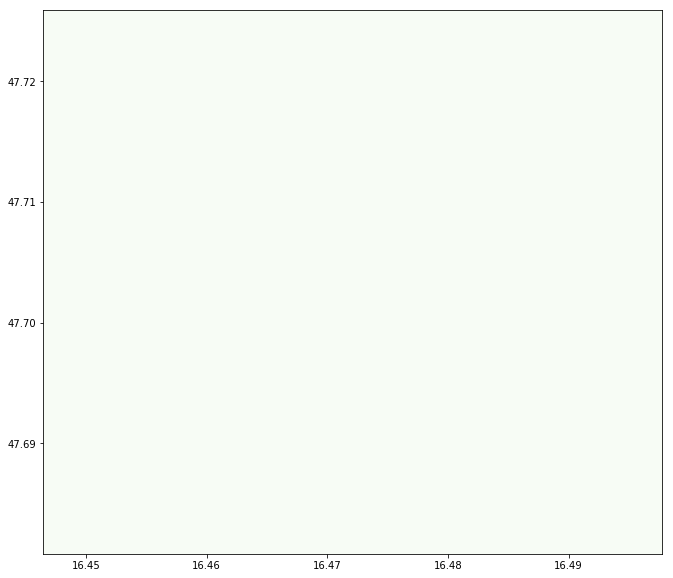

{
  "metadata": [
    {
      "date": "Thu Sep 13 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 0
    },
    {
      "date": "Mon Sep 10 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 1
    },
    {
      "date": "Sat Sep 08 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 2
    },
    {
      "date": "Wed Sep 05 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 3
    },
    {
      "date": "Mon Sep 03 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 4
    }
  ],
  "debug": [],
  "date_created": "Fri Mar 27 2020 13:03:27 GMT+0000 (UTC)",
  "time": [
    "2018-09-01T11:59:59.500000",
    "2018-09-15T11:59:59.500000"
  ]
}


In [11]:
file = io.BytesIO(response.content)
tar = tarfile.open(fileobj=file, mode="r")
tar.list()
tar.extractall('../testing/')#('B04.tif', '../testing/')

with rasterio.open(tar.extractfile('B08.tif')) as tif:
    pyplot.figure(figsize=(16,10))
    show((tif,2), transform=tif.transform, cmap='Greens')

import json
with open('../testing/userdata.json') as userdata:
    parsed = json.load(userdata)
    print(json.dumps(parsed, indent=2))